# Predictive Maintenance

Predictive Maintenance is the maintenance of machines at a predicted future time before the machine failure. This allows scheduled maintenance of the machines, reducing the unplanned downtime costs.

In this notebook, we will build a deployable end-to-end classification model to predict whether a machine failure will occur or not. We will train state-of-the-art gradient boosted decision tree (GBDT) algorithms, and compare their performances.

# Data

It consists of 10,000 data points stored as rows with features like product type, air temperature, process temperature, rotational speed, torque wear, machine failure. The machine failures are grouped into 5 subcategories. For simplicity, we will predict the machine failure feature. A concise summary of the data, pair plots, and the distribution of the target variable are given below.

In [134]:
import os
import numpy as np
import pandas as pd
import pylab
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, LinearRegression, ElasticNet, ElasticNetCV
%config InlineBanckend.figure_formats = ['svg']
%matplotlib inline

In [96]:
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

### Target Distribution

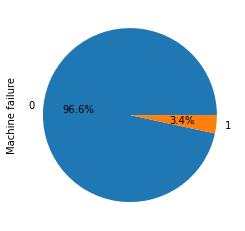

In [8]:
df['Machine failure'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()


### Subgroups of the machine failure

In [11]:
df[df['Machine failure']==1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].apply(pd.value_counts)

,TWF,HDF,PWF,OSF,RNF
0,293,224,244,241,338
1,46,115,95,98,1


### plots

In [56]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


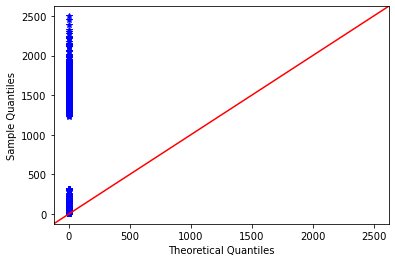

In [57]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab as py
data=df.drop(['Product ID', 'Type', 'UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).sample(1000).select_dtypes(include='number')

sm.qqplot(data= data, line = '45', marker='*')
py.show()


/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


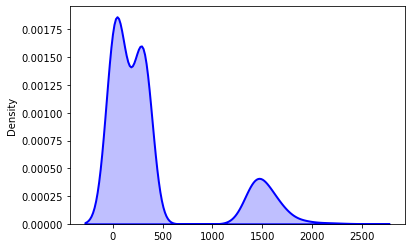

In [64]:
sns.distplot(data, hist=False, kde=True, kde_kws={'shade':True, 'linewidth':2},
            label='Non-Normal', color='blue')
py.show()


/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


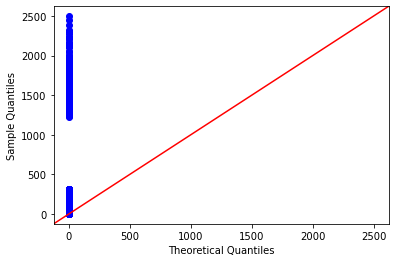

In [83]:
from scipy import stats
sm.qqplot(data, line='45')
py.show()

/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


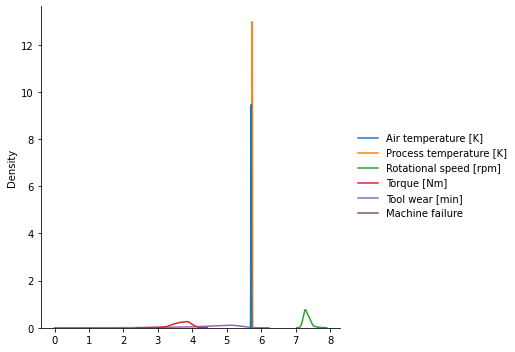

In [82]:
sns.displot(data, kind='kde')

/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


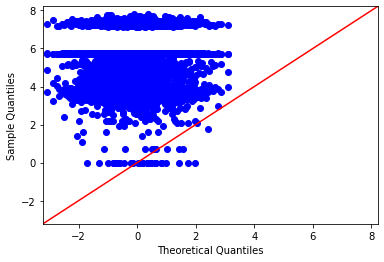

In [84]:
sm.qqplot(np.log(data), line='45')
py.show()

<AxesSubplot:ylabel='Density'>

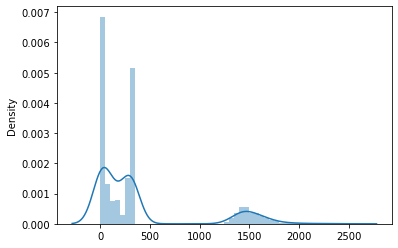

In [89]:
sns.distplot(data, kde=True)

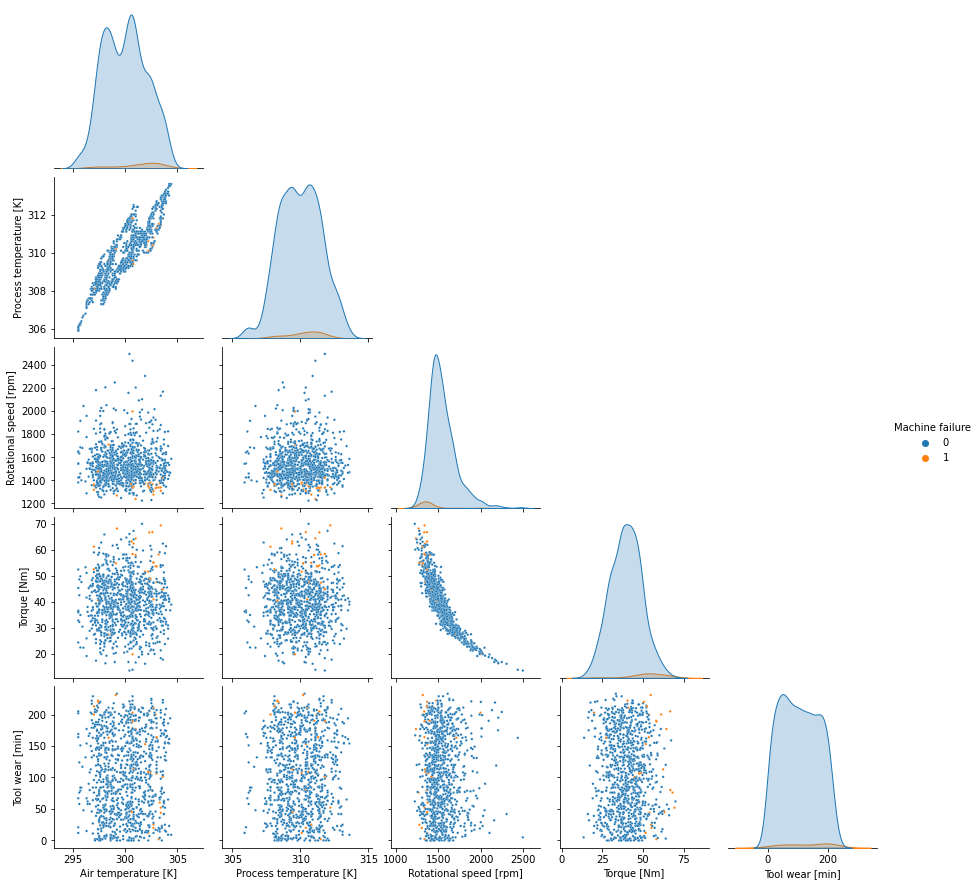

In [29]:
def plot_pair(): 
    sns.pairplot(data=df.drop(['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1).sample(1000).select_dtypes(include='number'),
                               hue='Machine failure',
                               plot_kws = {'s':6},
                               corner=True)
    plt.show()
plot_pair()

### Profiling


In [19]:
pf = ProfileReport(df)
pf.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

 - Variables  
There are 14 variables in total out of which, 8 variables represent the input features. Machine Failure is the output/prediction. TWF, HDF, PWF, OSF, RNF are those failures that are the different types of machine failures. they don't have any kind of missing values or duplicate rows.

 - Multi-collinearity     
Air temp, process temp, rotational speed, torque, UDI are those features that have high correlation among the input features rather than the output feature.

 - Not-Normal    
 The data is not normally distributed. 

In [99]:
df.head(2)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [98]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [100]:
df.Type.unique()

array(['M', 'L', 'H'], dtype=object)

In [140]:
x = df.drop(columns = ['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'])
y = df['Machine failure']

In [141]:
scaler = StandardScaler()
arr = scaler.fit_transform(x)
arr

array([[-0.95238944, -0.94735989,  0.06818514,  0.28219976, -1.69598374],
       [-0.90239341, -0.879959  , -0.72947151,  0.63330802, -1.6488517 ],
       [-0.95238944, -1.01476077, -0.22744984,  0.94428963, -1.61743034],
       ...,
       [-0.50242514, -0.94735989,  0.59251888, -0.66077672, -1.35034876],
       [-0.50242514, -0.879959  , -0.72947151,  0.85400464, -1.30321671],
       [-0.50242514, -0.879959  , -0.2162938 ,  0.02137647, -1.22466331]])

In [142]:
df1 = pd.DataFrame(arr)
df1

,0,1,2,3,4
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430
3,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009
4,-0.902393,-0.879959,-0.729472,0.001313,-1.554588
...,...,...,...,...,...
9995,-0.602417,-1.082162,0.363820,-1.052012,-1.476034
9996,-0.552421,-1.082162,0.520005,-0.821283,-1.428902
9997,-0.502425,-0.947360,0.592519,-0.660777,-1.350349
9998,-0.502425,-0.879959,-0.729472,0.854005,-1.303217


In [143]:
arr2 = arr.flatten()
arr3 = abs(arr2)
arr3

array([0.95238944, 0.94735989, 0.06818514, ..., 0.2162938 , 0.02137647,
       1.22466331])

/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syeedakudhsiafatima/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


lambda value used for transformation: 0.45939210732196617


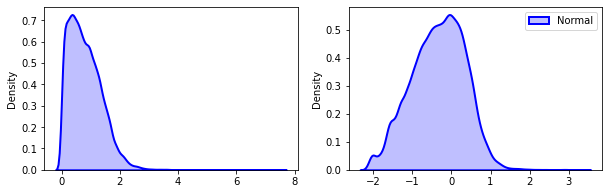

In [144]:
'''Converting non-normal distribution into a normally 
distributed data by using a box-cox transform'''

fitted_data, fitted_lambda = stats.boxcox(arr3)

fig, ax = plt.subplots(1,2)
sns.distplot(arr3, hist=False, kde=True, kde_kws={'shade':True,
                                                  'linewidth':2},
            label='Non-normal', color='blue', ax=ax[0])
sns.distplot(fitted_data,  hist=False, kde=True, kde_kws={'shade':
                                            True,'linewidth':2},
            label='Normal', color='blue', ax=ax[1])
plt.legend(loc='upper right')

fig.set_figheight(3)
fig.set_figwidth(10)
print(f'lambda value used for transformation: {fitted_lambda}')



In [145]:
df1.describe()

,0,1,2,3,4
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,6.965539e-17,3.841483e-15,-2.554568e-16,5.259244e-16,4.147793e-17
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-2.352278e+00,-2.901986e+00,-2.068196e+00,-3.630149e+00,-1.695984e+00
25%,-8.523974e-01,-8.125581e-01,-6.458012e-01,-6.808401e-01,-8.633176e-01
50%,4.753123e-02,6.365340e-02,-1.995597e-01,1.134481e-02,7.698234e-04
75%,7.474757e-01,7.376623e-01,4.084443e-01,6.834663e-01,8.491466e-01
max,2.247357e+00,2.557486e+00,7.514840e+00,3.672902e+00,2.278819e+00


In [146]:
#checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
arr.shape

(10000, 5)

In [147]:
vif_df = pd.DataFrame()

In [148]:
vif_df['vif'] = [variance_inflation_factor (arr,i) for i in range(arr.shape[1])]
vif_df['features'] = x.columns

In [149]:
vif_df

,vif,features
0,4.303979,Air temperature [K]
1,4.302788,Process temperature [K]
2,4.270132,Rotational speed [rpm]
3,4.268850,Torque [Nm]
4,1.000237,Tool wear [min]


vif is < 10, no need to eliminate any column.

In [171]:
#split the data into training/testing dataset to validate model
x_train, x_test, y_train, y_test = train_test_split(arr, y, test_size=0.2, random_state = 23)


In [172]:
x_train

array([[-0.60241721, -0.67775635, -0.23302786,  0.3825164 ,  0.61348639],
       [ 1.69740034,  1.14206757, -1.03626252,  0.4126114 ,  1.32046704],
       [-0.50242514,  0.19845517,  0.6594551 , -0.90153668, -0.59623606],
       ...,
       [-0.55242117,  0.0636534 ,  0.21321362,  0.14175645, -0.43912925],
       [-0.90239341, -0.61035546,  0.16858947, -0.48020676,  1.43044181],
       [-1.25236565, -1.01476077,  0.89373188, -0.99182166, -1.0675565 ]])

In [173]:
y_train

52      0
4720    1
1448    0
9354    0
8123    0
       ..
347     0
6175    0
9704    0
9256    0
8787    0
Name: Machine failure, Length: 8000, dtype: int64

In [174]:
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [175]:
pickle.dump(lr, open('Predictive maintenance.pickle', 'wb'))

In [176]:
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [177]:
lr.predict([[298.8, 308.4, 1604, 29.5, 14]])

array([160.7320022])